In [224]:
import os
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np


In [144]:
def build_csv(real_folder, fake_folder, output_csv):
    image_exts = ('.jpg', '.jpeg', '.png')

    real_images = [os.path.join(real_folder, f) for f in os.listdir(real_folder) if f.lower().endswith(image_exts)]
    fake_images = [os.path.join(fake_folder, f) for f in os.listdir(fake_folder) if f.lower().endswith(image_exts)]

    df_real = pd.DataFrame({'path': real_images, 'label': 'Real'})
    df_fake = pd.DataFrame({'path': fake_images, 'label': 'Fake'})
    df = pd.concat([df_real, df_fake], ignore_index=True)

    df.to_csv(output_csv, index=False)
    print(f"Saved {len(df)} entries to {output_csv}")
    return df

build_csv("Dataset/Real", "Dataset/Fake", "Dataset/dataset_rebuilt.csv")

Saved 12890 entries to Dataset/dataset_rebuilt.csv


,path,label
0,Dataset/Real/02725.jpg,Real
1,Dataset/Real/real_433_aug_0.jpg,Real
2,Dataset/Real/real_119_aug_0.jpg,Real
3,Dataset/Real/02043.jpg,Real
4,Dataset/Real/real_523_aug_2.jpg,Real
...,...,...
12885,Dataset/Fake/fake_221_aug_4.jpg,Fake
12886,Dataset/Fake/1IOTYKHXOX.jpg,Fake
12887,Dataset/Fake/2G5HUN26L3.jpg,Fake
12888,Dataset/Fake/fake_625_aug_3.jpg,Fake


In [146]:
def prepare_data(csv_path, sample_size=2000):
    df = pd.read_csv(csv_path)
    df['label'] = df['label'].map({'Fake': 0, 'Real': 1})
    
    df_sample = df.sample(n=sample_size, random_state=42).reset_index(drop=True)
    
    train_val_df, test_df = train_test_split(df_sample, test_size=0.2, stratify=df_sample['label'], random_state=42)
    train_df, val_df = train_test_split(train_val_df, test_size=0.1, stratify=train_val_df['label'], random_state=42)
    
    return train_df, val_df, test_df

train_df, val_df, test_df = prepare_data("Dataset/dataset_rebuilt.csv")

In [152]:
class FaceDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'path']
        label = self.df.loc[idx, 'label']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label


In [154]:
def get_dataloaders(train_df, val_df, test_df, batch_size=32):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])

    train_loader = DataLoader(FaceDataset(train_df, transform), batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(FaceDataset(val_df, transform), batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(FaceDataset(test_df, transform), batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = get_dataloaders(train_df, val_df, test_df)


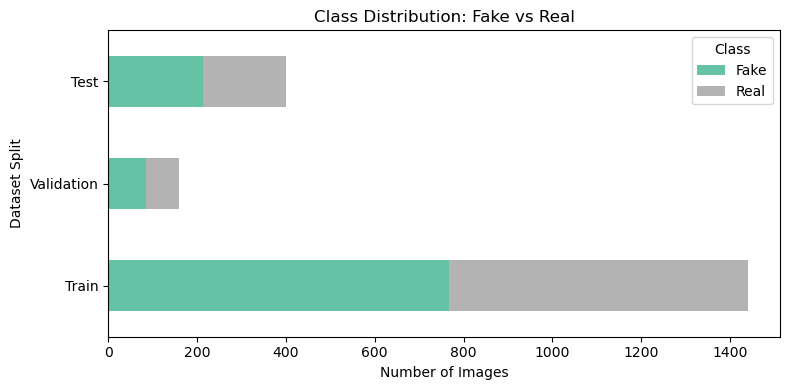

In [156]:
def plot_label_distribution(train_df, val_df, test_df):
    dist_df = pd.DataFrame({
        'Train': train_df['label'].value_counts().sort_index(),
        'Validation': val_df['label'].value_counts().sort_index(),
        'Test': test_df['label'].value_counts().sort_index()
    }).T
    dist_df.columns = ['Fake', 'Real']

    dist_df.plot(kind='barh', stacked=True, figsize=(8, 4), colormap='Set2')
    plt.title("Class Distribution: Fake vs Real")
    plt.xlabel("Number of Images")
    plt.ylabel("Dataset Split")
    plt.legend(title="Class")
    plt.tight_layout()
    plt.show()

plot_label_distribution(train_df, val_df, test_df)


In [158]:
# Load and prepare the data
df = pd.read_csv("Dataset/dataset_rebuilt.csv")
df['label'] = df['label'].map({'Fake': 0, 'Real': 1})

# Sample 2,000 rows
df_sample = df.sample(n=2000, random_state=42).reset_index(drop=True)

# Split 80% (train+val) / 20% test
train_val_df, test_df = train_test_split(
    df_sample, test_size=0.2, stratify=df_sample['label'], random_state=42
)

# From train_val, split 10% as validation
train_df, val_df = train_test_split(
    train_val_df, test_size=0.1, stratify=train_val_df['label'], random_state=42
)

# Neatly print dataset summary
print(" Dataset Split Summary")
print("-" * 30)
print(f"Train size     : {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size      : {len(test_df)}")
print("-" * 30)

# Print label distributions
print("\n Label Distributions:\n")

print("Train:")
print(train_df['label'].value_counts().to_string())
print("\nValidation:")
print(val_df['label'].value_counts().to_string())
print("\nTest:")
print(test_df['label'].value_counts().to_string())


 Dataset Split Summary
------------------------------
Train size     : 1440
Validation size: 160
Test size      : 400
------------------------------

 Label Distributions:

Train:
label
0    767
1    673

Validation:
label
0    85
1    75

Test:
label
0    213
1    187


In [24]:
pip install timm


Note: you may need to restart the kernel to use updated packages.


In [216]:
import torch
import torch.nn as nn
import timm
from torch.optim import Adam
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score



---------------------------------------------------------------------------------------------------------------

Model 1: Xception

For the first model, I used Xception, a powerful CNN that’s great at understanding image features. It was originally trained on ImageNet, so I just fine-tuned it for my task of classifying images as Real or Fake. I replaced the final layer to fit two classes and tracked its performance using accuracy, loss trends, and a confusion matrix.

In [162]:
# Load pre-trained Xception from timm
model = timm.create_model('xception', pretrained=True)

# Replace the final fully connected layer for 2-class classification
model.fc = nn.Linear(model.fc.in_features, 2)

# Move to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4)


/opt/anaconda3/lib/python3.12/site-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


In [164]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, correct = 0.0, 0
    for images, labels in tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

    avg_loss = running_loss / len(loader)
    accuracy = correct / len(loader.dataset)
    return avg_loss, accuracy


def validate(model, loader, criterion, device):
    model.eval()
    running_loss, correct = 0.0, 0
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation", leave=False):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

    avg_loss = running_loss / len(loader)
    accuracy = correct / len(loader.dataset)
    return avg_loss, accuracy


In [32]:
num_epochs = 5
best_val_acc = 0.0

train_losses, val_accuracies = [], []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_xception_model.pth")
        print(" Saved new best model!")



Epoch 1/5


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.4982 | Train Acc: 0.7771
Val   Loss: 0.3000 | Val   Acc: 0.8688
 Saved new best model!

Epoch 2/5


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.1565 | Train Acc: 0.9542
Val   Loss: 0.2833 | Val   Acc: 0.8812
 Saved new best model!

Epoch 3/5


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0513 | Train Acc: 0.9903
Val   Loss: 0.3292 | Val   Acc: 0.8812

Epoch 4/5


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0245 | Train Acc: 0.9958
Val   Loss: 0.3157 | Val   Acc: 0.9000
 Saved new best model!

Epoch 5/5


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0090 | Train Acc: 0.9993
Val   Loss: 0.2732 | Val   Acc: 0.9125
 Saved new best model!


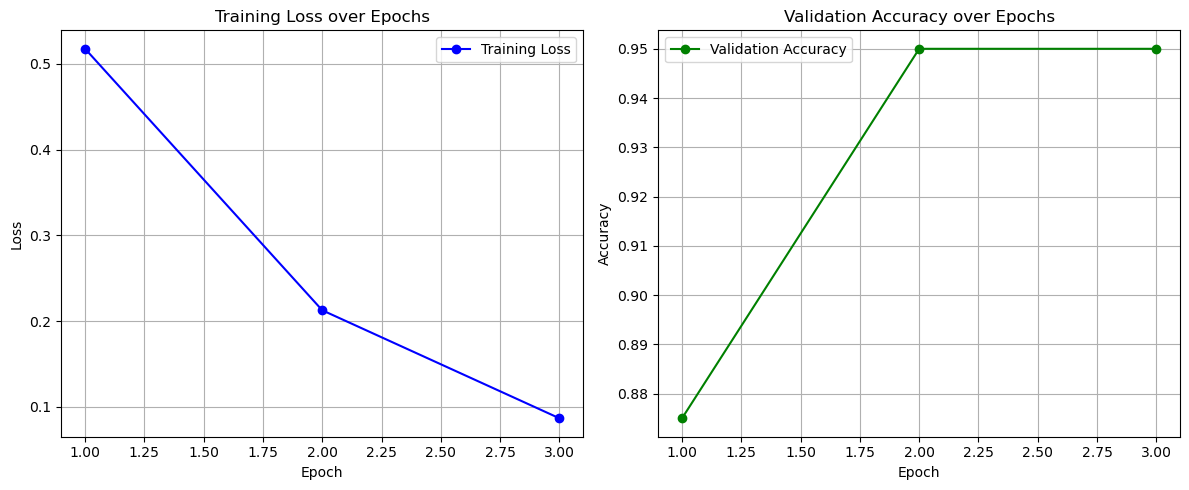

In [166]:
def plot_training_metrics(train_losses, val_accuracies):
    epochs = list(range(1, len(train_losses) + 1))

    plt.figure(figsize=(12, 5))

    # Training Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, marker='o', color='blue', label='Training Loss')
    plt.title("Training Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, marker='o', color='green', label='Validation Accuracy')
    plt.title("Validation Accuracy over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_metrics(train_losses, val_accuracies)


In [168]:
def print_classification_report(model, loader, device):
    from sklearn.metrics import classification_report
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    target_names = ['Fake', 'Real']
    print(classification_report(all_labels, all_preds, target_names=target_names))

print_classification_report(model, test_loader, device)


              precision    recall  f1-score   support

        Fake       0.63      0.28      0.39       213
        Real       0.50      0.81      0.62       187

    accuracy                           0.53       400
   macro avg       0.56      0.55      0.50       400
weighted avg       0.57      0.53      0.50       400



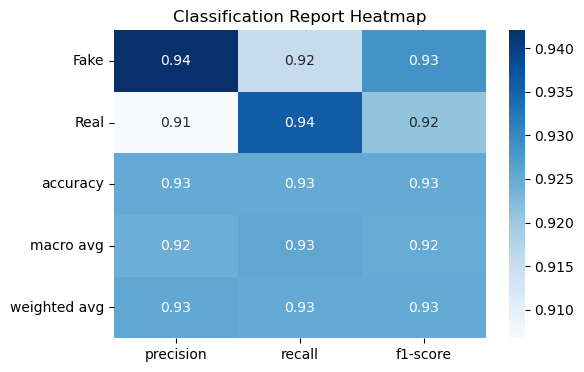

In [64]:
def print_and_plot_classification_report(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    target_names = ['Fake', 'Real']
    report = classification_report(all_labels, all_preds, target_names=target_names, output_dict=True)

    # Convert to DataFrame for seaborn heatmap
    df_report = pd.DataFrame(report).iloc[:-1, :].T  # Exclude 'accuracy', keep precision/recall/f1-score

    # Plot heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(df_report, annot=True, cmap='Blues', fmt=".2f")
    plt.title("Classification Report Heatmap")
    plt.show()

# Usage
print_and_plot_classification_report(model, test_loader, device)


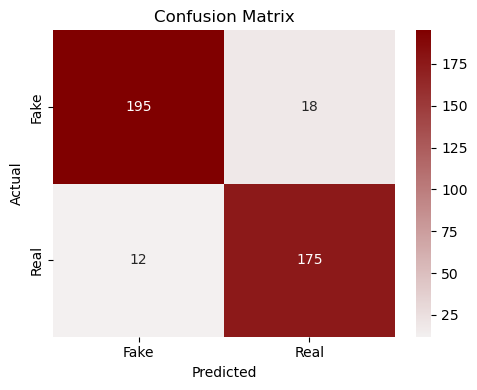

In [86]:
def plot_confusion_matrix(model, loader, device, class_names=['Fake', 'Real']):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d',
                cmap=sns.color_palette("light:#800000", as_cmap=True),  
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()
    
plot_confusion_matrix(model, test_loader, device)

-----------------------------------------------------------------------------------------------------------------

Model 2: EfficientNet-B0

For the second model, I used EfficientNet-B0, a highly efficient CNN known for its balance between speed and accuracy. Like with Xception, I fine-tuned a version pretrained on ImageNet for the Real vs. Fake classification task. I replaced the final layer with a binary classifier and monitored its performance through accuracy, loss curves, and a confusion matrix.

In [104]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension --sys-prefix


usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: console dejavu events execute kernel kernelspec lab
labextension labhub migrate nbconvert notebook qtconsole run server
troubleshoot trust

Jupyter command `jupyter-nbextension` not found.


In [110]:
# Load pre-trained EfficientNet-B0 from timm
model = timm.create_model('efficientnet_b0', pretrained=True)

# Replace the final fully connected layer for 2-class classification
model.classifier = nn.Linear(model.classifier.in_features, 2)

# Move to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4)


In [112]:
num_epochs = 3
best_val_acc = 0.0

train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_efficientnet_b0_model.pth")
        print(" Saved new best model!")



Epoch 1/3


Train Loss: 0.5175 | Train Acc: 0.7681
Val   Loss: 0.2921 | Val   Acc: 0.8750
 Saved new best model!

Epoch 2/3


Train Loss: 0.2127 | Train Acc: 0.9313
Val   Loss: 0.1516 | Val   Acc: 0.9500
 Saved new best model!

Epoch 3/3


Train Loss: 0.0868 | Train Acc: 0.9722
Val   Loss: 0.1267 | Val   Acc: 0.9500


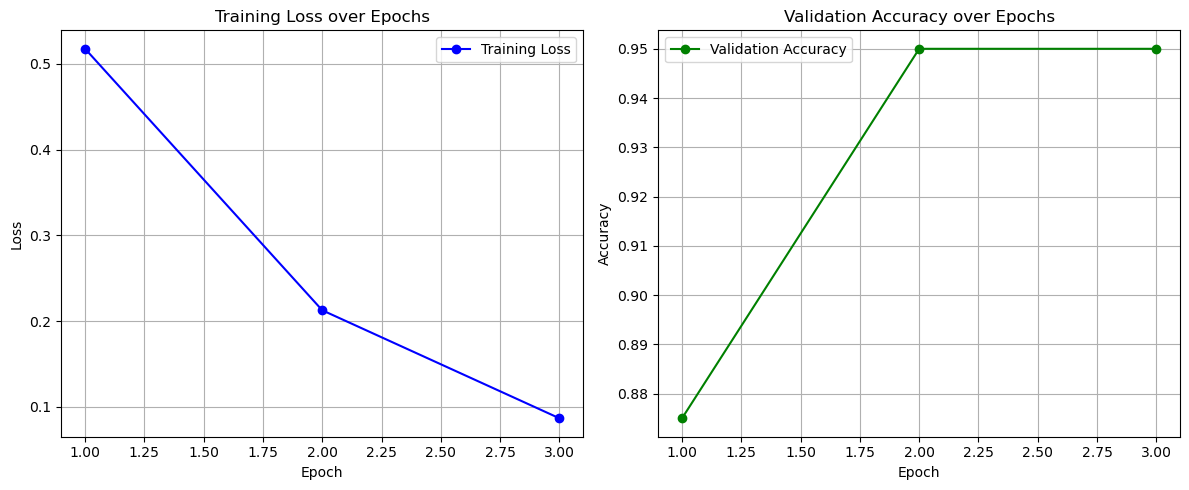

In [170]:
plot_training_metrics(train_losses, val_accuracies)


In [121]:
print_classification_report(model, test_loader, device)


              precision    recall  f1-score   support

        Fake       0.93      0.95      0.94       213
        Real       0.94      0.92      0.93       187

    accuracy                           0.94       400
   macro avg       0.94      0.93      0.93       400
weighted avg       0.94      0.94      0.93       400



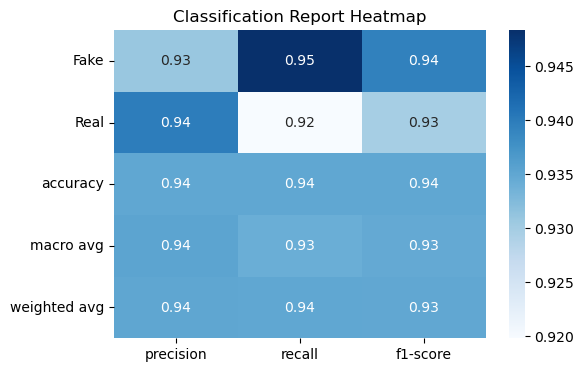

In [125]:
print_and_plot_classification_report(model, test_loader, device)


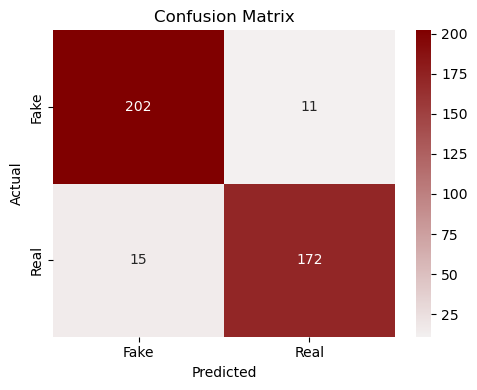

In [127]:
plot_confusion_matrix(model, test_loader, device)


-------------------------------------------------------------------------------------------------------------------------

Model 3: ResNet50

For the final model, I went with ResNet50, a classic deep learning architecture that uses skip connections to make training easier and more stable. Just like before, I fine-tuned a pretrained version on ImageNet and adapted it for the Real vs. Fake classification task. I swapped out the last layer for binary output and tracked how it performed using accuracy, loss curves, and a confusion matrix.

In [172]:
# Load pre-trained ResNet50 from timm
model = timm.create_model('resnet50', pretrained=True)

# Replace the final fully connected layer for 2-class classification
model.fc = nn.Linear(model.fc.in_features, 2)

# Move to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4)


model.safetensors:  48%|####7     | 94.4M/197M [00:00<?, ?B/s]

In [176]:
num_epochs = 6
best_val_acc = 0.0

train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_resnet50_model.pth")
        print(" Saved new best model!")



Epoch 1/6


Train Loss: 0.3489 | Train Acc: 0.8951
Val   Loss: 0.3335 | Val   Acc: 0.8500
 Saved new best model!

Epoch 2/6


Train Loss: 0.1919 | Train Acc: 0.9507
Val   Loss: 0.2777 | Val   Acc: 0.8688
 Saved new best model!

Epoch 3/6


Train Loss: 0.1034 | Train Acc: 0.9785
Val   Loss: 0.2449 | Val   Acc: 0.9000
 Saved new best model!

Epoch 4/6


Train Loss: 0.0563 | Train Acc: 0.9896
Val   Loss: 0.2558 | Val   Acc: 0.8812

Epoch 5/6


Train Loss: 0.0339 | Train Acc: 0.9958
Val   Loss: 0.2671 | Val   Acc: 0.9062
 Saved new best model!

Epoch 6/6


Train Loss: 0.0220 | Train Acc: 0.9972
Val   Loss: 0.2635 | Val   Acc: 0.8875


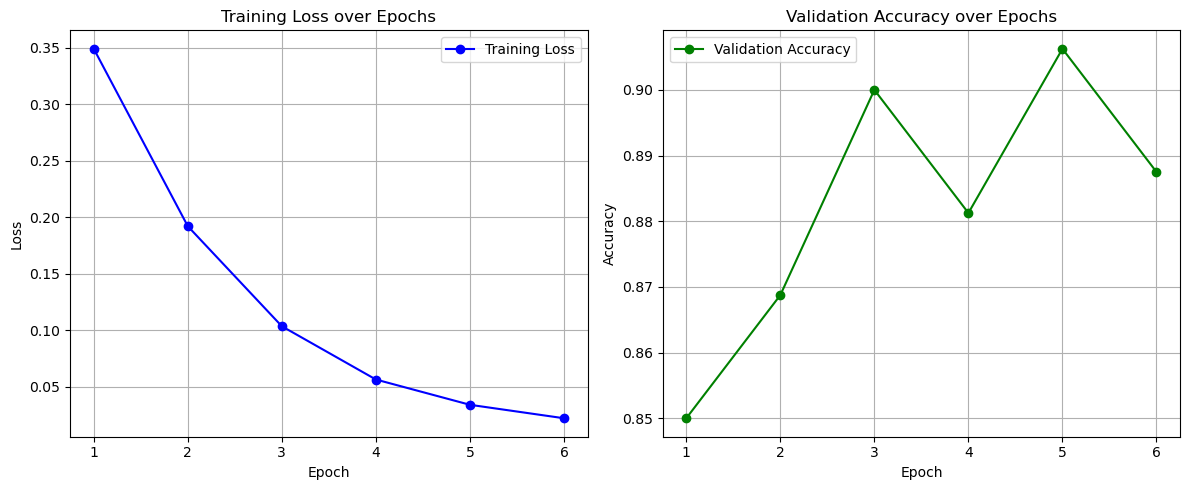

In [178]:
plot_training_metrics(train_losses, val_accuracies)


In [184]:
print_classification_report(model, test_loader, device)


              precision    recall  f1-score   support

        Fake       0.87      0.87      0.87       213
        Real       0.86      0.86      0.86       187

    accuracy                           0.86       400
   macro avg       0.86      0.86      0.86       400
weighted avg       0.86      0.86      0.86       400



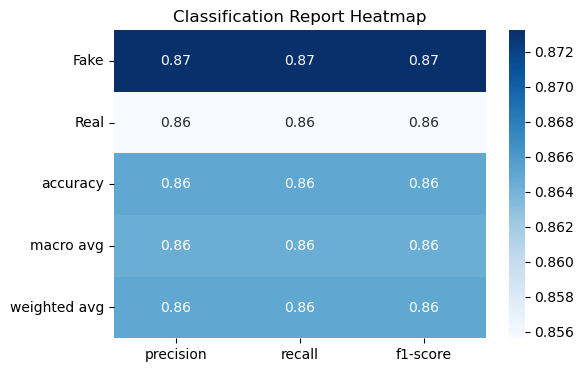

In [180]:
print_and_plot_classification_report(model, test_loader, device)


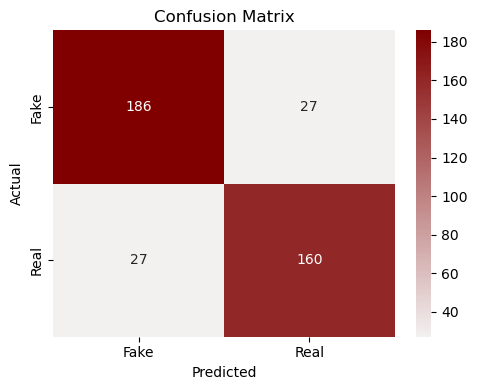

In [182]:
plot_confusion_matrix(model, test_loader, device)


In [192]:
def evaluate_model_on_test(model, test_loader, device, model_name="Model"):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Text Report
    print(f"\n📋 {model_name} - Classification Report")
    print(classification_report(all_labels, all_preds, target_names=['Fake', 'Real']))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
                xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # Return summary for comparison table
    report_dict = classification_report(all_labels, all_preds, target_names=['Fake', 'Real'], output_dict=True)
    return {
        "model": model_name,
        "accuracy": report_dict["accuracy"],
        "f1_fake": report_dict["Fake"]["f1-score"],
        "f1_real": report_dict["Real"]["f1-score"]
    }


In [196]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Xception
xception_model = timm.create_model('xception', pretrained=False)
xception_model.fc = nn.Linear(xception_model.fc.in_features, 2)
xception_model.load_state_dict(torch.load("models/best_xception_model.pth", map_location=device))
xception_model.to(device)

# Load EfficientNet-B0
efficientnet_model = timm.create_model('efficientnet_b0', pretrained=False)
efficientnet_model.classifier = nn.Linear(efficientnet_model.classifier.in_features, 2)
efficientnet_model.load_state_dict(torch.load("models/best_efficientnet_b0_model.pth", map_location=device))
efficientnet_model.to(device)

# Load ResNet50
resnet_model = timm.create_model('resnet50', pretrained=False)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 2)
resnet_model.load_state_dict(torch.load("models/best_resnet50_model.pth", map_location=device))
resnet_model.to(device)


/opt/anaconda3/lib/python3.12/site-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     


📋 Xception - Classification Report
              precision    recall  f1-score   support

        Fake       0.94      0.92      0.93       213
        Real       0.91      0.94      0.92       187

    accuracy                           0.93       400
   macro avg       0.92      0.93      0.92       400
weighted avg       0.93      0.93      0.93       400



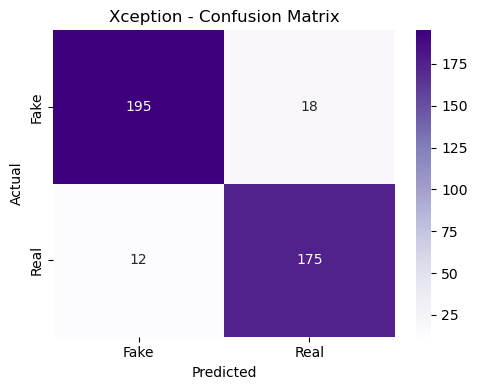


📋 EfficientNet-B0 - Classification Report
              precision    recall  f1-score   support

        Fake       0.94      0.94      0.94       213
        Real       0.94      0.94      0.94       187

    accuracy                           0.94       400
   macro avg       0.94      0.94      0.94       400
weighted avg       0.94      0.94      0.94       400



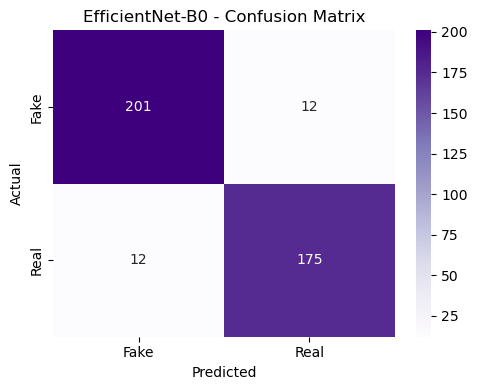


📋 ResNet50 - Classification Report
              precision    recall  f1-score   support

        Fake       0.86      0.91      0.88       213
        Real       0.89      0.83      0.86       187

    accuracy                           0.87       400
   macro avg       0.87      0.87      0.87       400
weighted avg       0.87      0.87      0.87       400



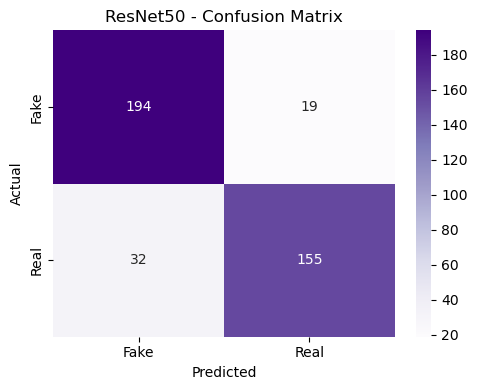

{'model': 'ResNet50',
 'accuracy': 0.8725,
 'f1_fake': 0.8838268792710706,
 'f1_real': 0.8587257617728532}

In [198]:
evaluate_model_on_test(xception_model, test_loader, device, "Xception")
evaluate_model_on_test(efficientnet_model, test_loader, device, "EfficientNet-B0")
evaluate_model_on_test(resnet_model, test_loader, device, "ResNet50")


In [218]:
def evaluate_model_on_test(model, loader, device, model_name):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    print(f"{model_name} Test Accuracy: {acc * 100:.2f}%")
    return acc

x_acc = evaluate_model_on_test(xception_model, test_loader, device, "Xception")
e_acc = evaluate_model_on_test(efficientnet_model, test_loader, device, "EfficientNet-B0")
r_acc = evaluate_model_on_test(resnet_model, test_loader, device, "ResNet50")


Xception Test Accuracy: 92.50%
EfficientNet-B0 Test Accuracy: 94.00%
ResNet50 Test Accuracy: 87.25%


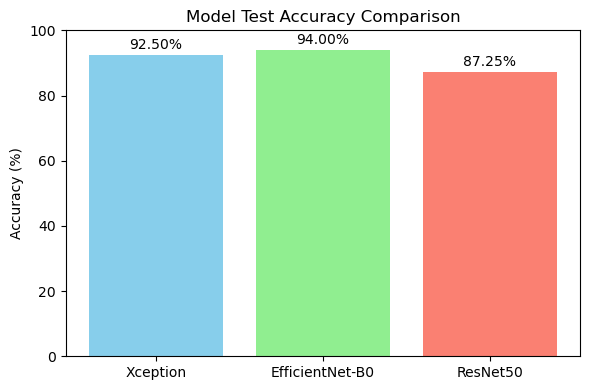

In [220]:

model_names = ["Xception", "EfficientNet-B0", "ResNet50"]
accuracies = [x_acc, e_acc, r_acc]

plt.figure(figsize=(6, 4))
bars = plt.bar(model_names, [a * 100 for a in accuracies], color=['skyblue', 'lightgreen', 'salmon'])
plt.ylim(0, 100)
plt.title("Model Test Accuracy Comparison")
plt.ylabel("Accuracy (%)")

# Add values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f'{yval:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()


---------------------------------------------------------------------------------------------------------------------

Ensemble Model Summary

After training Xception, EfficientNet-B0, and ResNet50 separately, I combined all three into a single ensemble to boost overall performance. Instead of relying on just one model’s prediction, the ensemble takes the average output from all three and makes a more balanced decision. This way, each model’s strengths help cover the weaknesses of the others. The result is a more accurate and reliable classifier for telling apart Real and Fake images.










In [200]:
class EnsembleModel(nn.Module):
    def __init__(self, model1, model2, model3):
        super(EnsembleModel, self).__init__()
        self.model1 = model1.eval()
        self.model2 = model2.eval()
        self.model3 = model3.eval()

    def forward(self, x):
        with torch.no_grad():
            out1 = F.softmax(self.model1(x), dim=1)
            out2 = F.softmax(self.model2(x), dim=1)
            out3 = F.softmax(self.model3(x), dim=1)

        avg_output = (out1 + out2 + out3) / 3
        return avg_output


In [202]:
ensemble_model = EnsembleModel(xception_model, efficientnet_model, resnet_model).to(device)


In [206]:
import torch.nn.functional as F

all_preds = []
all_labels = []

ensemble_model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = ensemble_model(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())


In [209]:
print(" Ensemble Model - Classification Report")
print(classification_report(all_labels, all_preds, target_names=['Fake', 'Real']))


 Ensemble Model - Classification Report
              precision    recall  f1-score   support

        Fake       0.93      0.93      0.93       213
        Real       0.92      0.91      0.92       187

    accuracy                           0.92       400
   macro avg       0.92      0.92      0.92       400
weighted avg       0.92      0.92      0.92       400



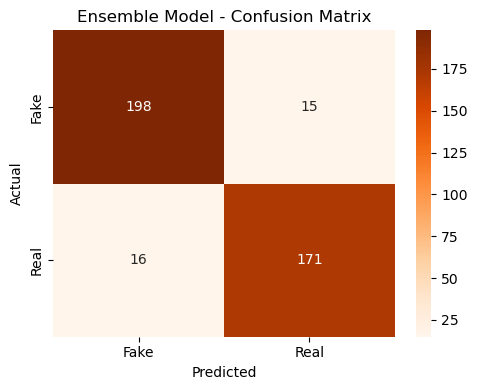

In [211]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title("Ensemble Model - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [226]:
def evaluate_model_on_test(model, loader, device, model_name):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    print(f"{model_name} Test Accuracy: {acc * 100:.2f}%")
    return acc

# Run evaluation on each model
test_acc_x = evaluate_model_on_test(xception_model, test_loader, device, "Xception")
test_acc_e = evaluate_model_on_test(efficientnet_model, test_loader, device, "EfficientNet-B0")
test_acc_r = evaluate_model_on_test(resnet_model, test_loader, device, "ResNet50")
test_acc_ensemble = evaluate_model_on_test(ensemble_model, test_loader, device, "Ensemble")



Xception Test Accuracy: 92.50%
EfficientNet-B0 Test Accuracy: 94.00%
ResNet50 Test Accuracy: 87.25%
Ensemble Test Accuracy: 92.25%


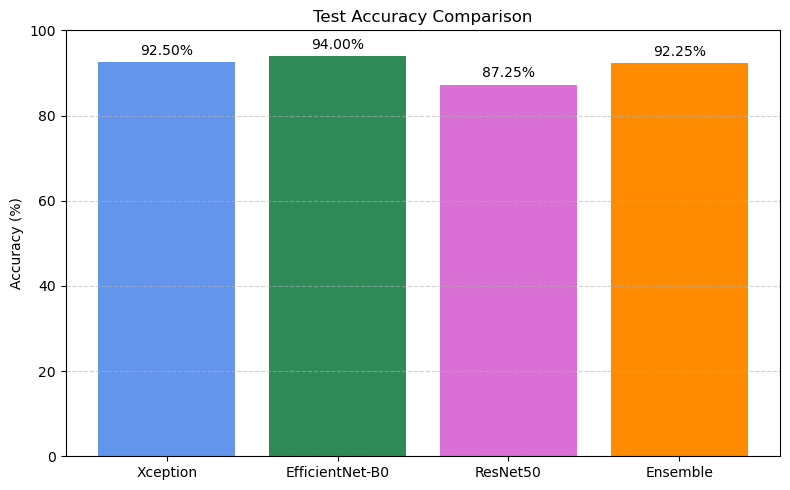

In [228]:
models = ['Xception', 'EfficientNet-B0', 'ResNet50', 'Ensemble']
test_accuracies = [test_acc_x * 100, test_acc_e * 100, test_acc_r * 100, test_acc_ensemble * 100]

plt.figure(figsize=(8, 5))
bars = plt.bar(models, test_accuracies, color=['cornflowerblue', 'seagreen', 'orchid', 'darkorange'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f"{yval:.2f}%", ha='center', va='bottom')

plt.title("Test Accuracy Comparison")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
